# Time Series Model for BCOM

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Import BCOM Data and Split to Train and Test

In [43]:
df =  pd.read_csv('BCOM.csv')
df['Date'] = pd.to_datetime(df['Date'])
df['Close'] = df[' Close']
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141 entries, 0 to 140
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    141 non-null    datetime64[ns]
 1    Open   141 non-null    float64       
 2    High   141 non-null    float64       
 3    Low    141 non-null    float64       
 4    Close  141 non-null    float64       
 5   Close   141 non-null    float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 6.7 KB


,Date,Open,High,Low,Close,Close
0,2022-07-26,119.34,119.34,119.34,119.34,119.34
1,2022-07-25,118.07,118.07,118.07,118.07,118.07
2,2022-07-22,116.52,116.52,116.52,116.52,116.52
3,2022-07-21,115.86,115.86,115.86,115.86,115.86
4,2022-07-20,117.55,117.55,117.55,117.55,117.55


In [44]:
bcom = df[['Date', 'Close']].copy() 

In [45]:
bcom_train = bcom[bcom['Date'].dt.month <= 6]
bcom_test = bcom[bcom['Date'].dt.month > 6]

print(bcom_train.shape, bcom_test.shape)

(124, 2) (17, 2)


### Define the Time Series Plot Function and view the data

In [46]:
def plot_entire_series(x, y, **kwargs):
    
    plt.figure(figsize=(16, 4))
    plt.plot(x, y, linewidth=2, color='black')
    
    for key, value in kwargs.items():
        plt.plot(x, value, linewidth=2, color=key)
        
    plt.xlabel('Date', fontsize=16)
    plt.ylabel('Close', fontsize=16)
    plt.show()
    
    return None

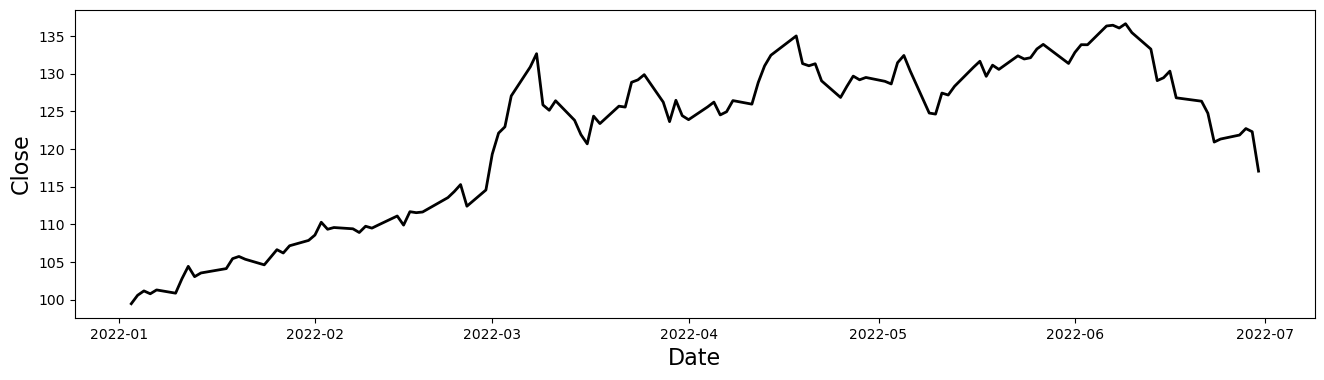

In [47]:
x = bcom_train['Date'].to_numpy()
y = bcom_train['Close'].to_numpy()

plot_entire_series(x, y)

### 1. Random Walk

In [48]:
bcom_train_rw = bcom_train.copy()

bcom_train_rw['CloseYesterday'] = bcom_train_rw['Close'].shift(1)
bcom_train_rw.head()

,Date,Close,CloseYesterday
17,2022-06-30,117.05,NaN
18,2022-06-29,122.28,117.05
19,2022-06-28,122.70,122.28
20,2022-06-27,121.84,122.70
21,2022-06-24,121.31,121.84


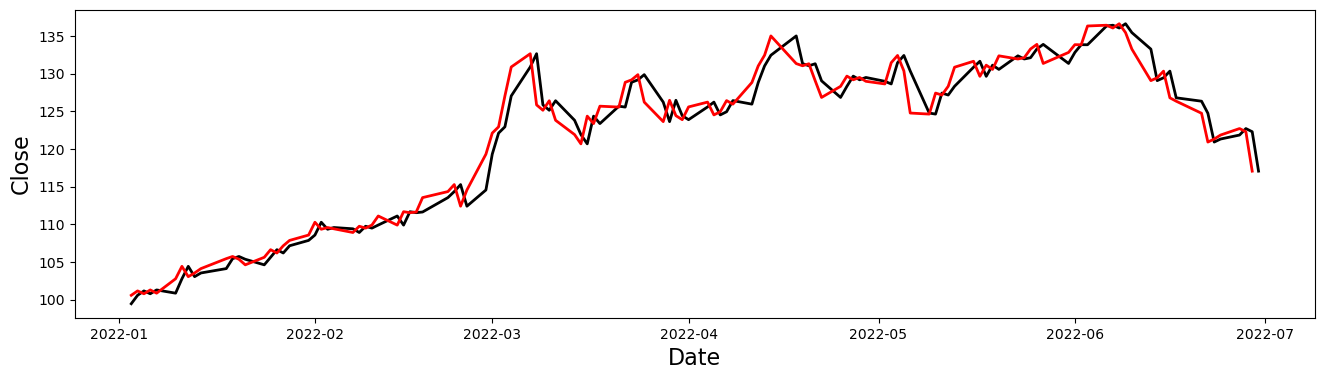

In [49]:
x = bcom_train_rw['Date'].to_numpy()
y = bcom_train_rw['Close'].to_numpy()
y_pred = bcom_train_rw['CloseYesterday'].to_numpy()

plot_entire_series(x, y, red = y_pred) 

### Zoom and see the last 50 prediction

In [50]:
def plot_last_fifty(x, y, **kwargs):
    
    plt.figure(figsize=(16, 4))
    plt.scatter(x[-50:], y[-50:], linewidth=3, color='black')
    plt.plot(x[-50:], y[-50:], linewidth=3, color='black')
    
    for key, value in kwargs.items():
        plt.plot(x[-50:], value[-50:], linewidth=3, color=key)
        
    plt.xlabel('Date', fontsize=16)
    plt.ylabel('Close', fontsize=16)
    plt.show()
    
    return None

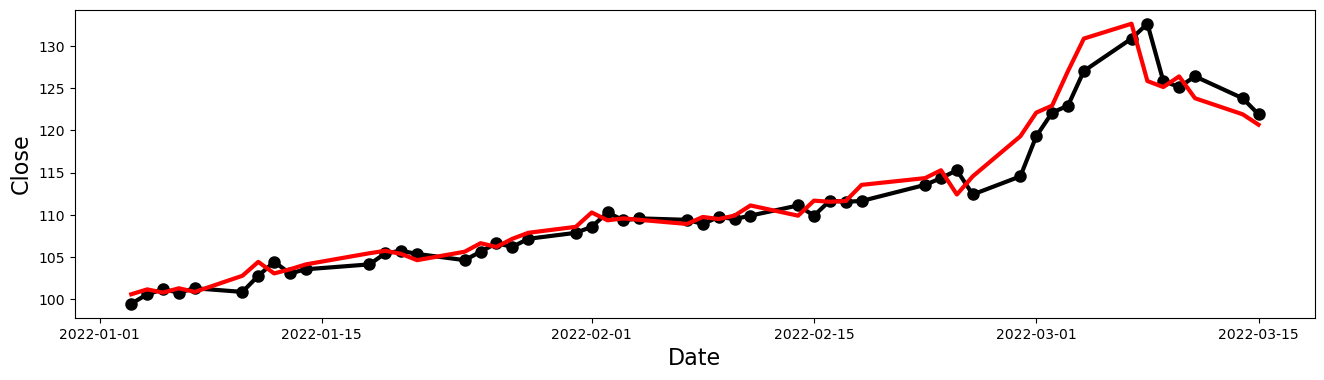

In [51]:
plot_last_fifty(x, y, red = y_pred)

In [52]:
print((abs(bcom_train_rw['Close'] - 
           bcom_train_rw['CloseYesterday']) >= 3).value_counts())

False    111
True      13
dtype: int64


In [53]:
from sklearn.metrics import r2_score

# Here we slice the series using [1:] in order to discard the first entry which corresponds to a NaN.
print('Training R2:', round(r2_score(bcom_train_rw['Close'][1:], bcom_train_rw['CloseYesterday'][1:]), 5))

Training R2: 0.96629


### 2. Auto-Regress Model

In [54]:
bcom_train_ar = bcom_train_rw.copy() 

In [55]:
import statsmodels.formula.api as smf

ar1 = smf.ols(formula='Close ~ CloseYesterday', data = bcom_train_ar).fit()
print(ar1.summary())

                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.966
Method:                 Least Squares   F-statistic:                     3488.
Date:                Tue, 26 Dec 2023   Prob (F-statistic):           4.54e-91
Time:                        14:02:26   Log-Likelihood:                -256.19
No. Observations:                 123   AIC:                             516.4
Df Residuals:                     121   BIC:                             522.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.1931      2.071     -0.

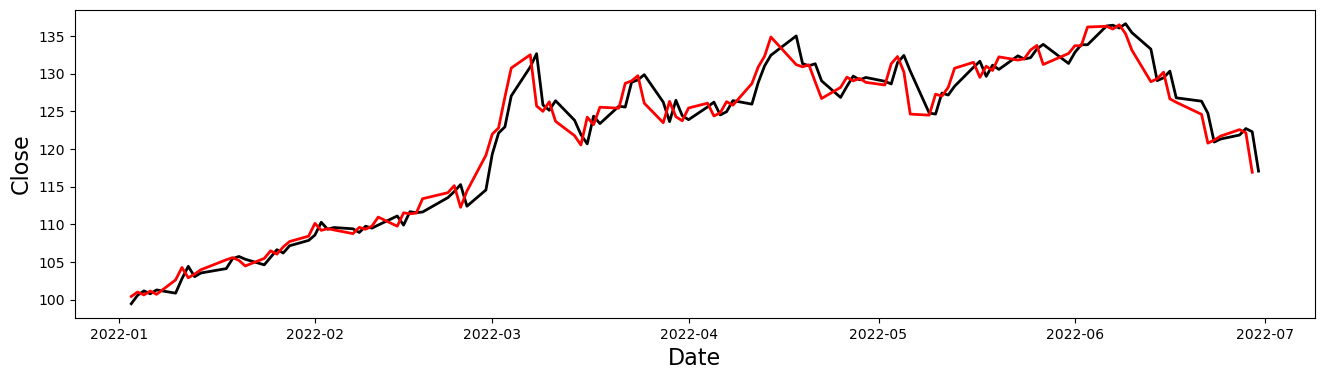

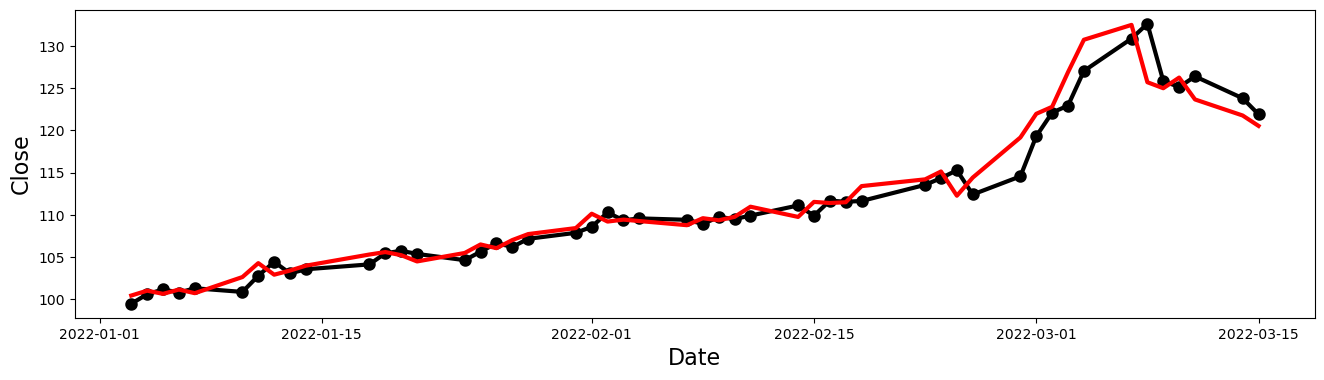

In [57]:
x = bcom_train_ar['Date'].to_numpy()
y = bcom_train_ar['Close'].to_numpy()
y_pred = ar1.predict(bcom_train_ar).to_numpy()

plot_entire_series(x, y, red=y_pred)
plot_last_fifty(x, y, red=y_pred) 

#### Higher-order Auto-regressive Model

In [59]:
bcom_train_ar['CloseTwoDaysAgo'] = bcom_train['Close'].shift(2)

ar2 = smf.ols(formula='Close ~ CloseYesterday + CloseTwoDaysAgo', data=bcom_train_ar).fit()
print(ar2.summary())

                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     1854.
Date:                Tue, 26 Dec 2023   Prob (F-statistic):           2.09e-90
Time:                        14:04:52   Log-Likelihood:                -250.01
No. Observations:                 122   AIC:                             506.0
Df Residuals:                     119   BIC:                             514.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.0519      2.049     

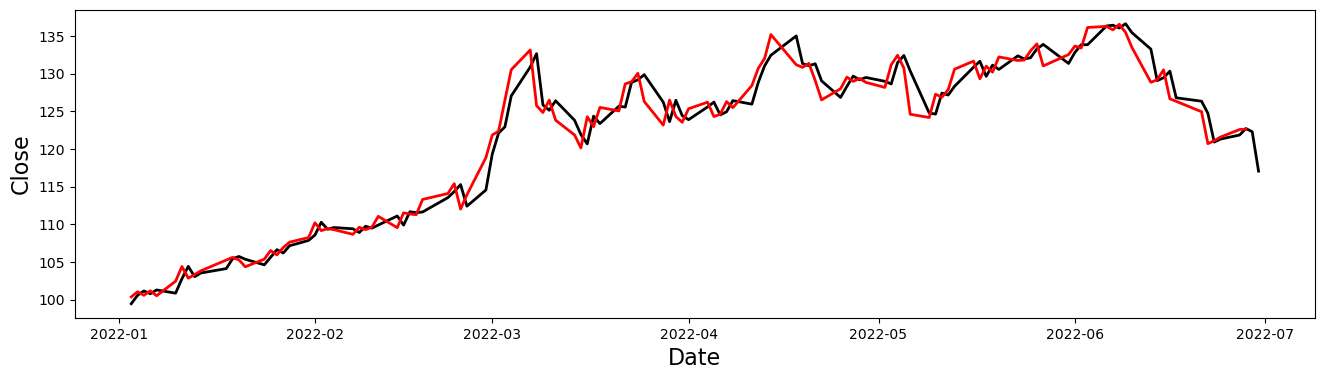

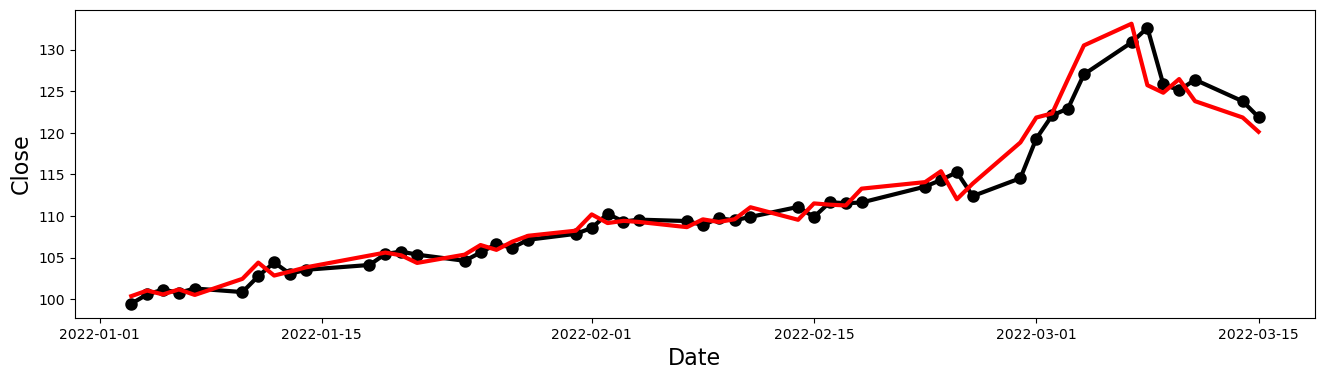

In [61]:
x = bcom_train_ar['Date'].to_numpy()
y = bcom_train_ar['Close'].to_numpy()
y_pred = ar2.predict(bcom_train_ar).to_numpy()

plot_entire_series(x, y, red=y_pred)
plot_last_fifty(x, y, red=y_pred) 